In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ============================================================
# 1. INSTALL DEPENDENCIES
# ============================================================

# NLP + Spark libs
!pip install -q nltk camel-tools pyspark==3.5.1 spark-nlp

# Java for Spark
!apt-get update -y
!apt-get install -y openjdk-11-jre-headless || apt-get install -y openjdk-17-jre-headless


Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,834 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,539 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,486 kB]
Hit:13 https://ppa.launchpadcontent.net/graphics-dri

In [ ]:
# ============================================================
# 2. IMPORT LIBRARIES
# ============================================================
import os
import json
import nltk
import pandas as pd

from nltk.tokenize import word_tokenize, sent_tokenize, WordPunctTokenizer
from nltk.util import ngrams
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import Laplace

from camel_tools.tokenizers.word import simple_word_tokenize as camel_simple_tokenize

# NLTK resources (IMPORTANT: includes punkt_tab)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

# Spark / Java env
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql import SparkSession
import pyspark.sql.functions as F


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
# ============================================================
# 3. LOAD DATA FROM GOOGLE DRIVE (JSONL)
# ============================================================
BASE_PATH = "/content/drive/MyDrive/NLP_Project/"

EN_JSONL = BASE_PATH + "NLP_English.jsonl"
AR_JSONL = BASE_PATH + "NLP_Arabic.jsonl"

english_articles = []
with open(EN_JSONL, "r", encoding="utf-8") as f:
    for line in f:
        record = json.loads(line)
        english_articles.append(record["text"])

arabic_articles = []
with open(AR_JSONL, "r", encoding="utf-8") as f:
    for line in f:
        record = json.loads(line)
        arabic_articles.append(record["text"])

print(f"Loaded {len(english_articles)} English articles.")
print(f"Loaded {len(arabic_articles)} Arabic articles.")

sample_english_article = english_articles[0]
sample_arabic_article  = arabic_articles[0]

print("\n--- English Sample ---")
print(sample_english_article[:150] + "...")

print("\n--- Arabic Sample ---")
print(sample_arabic_article[:150] + "...")


Loaded 326 English articles.
Loaded 418 Arabic articles.

--- English Sample ---
For all the interest in big-name witnesses and eye-opening private text messages, at the core of the defamation lawsuit filed by Dominion Voting Syste...

--- Arabic Sample ---
في زيارة رسمية إلى موسكو، عقد رئيس السلطة الانتقالية في بوركينا فاسو إبراهيم تراوري اجتماعا مع الرئيس الروسي فلاديمير بوتين، تمحور حول سبل تعزيز العلا...


In [ ]:
# ============================================================
# 4. TOKENIZATION (ENGLISH + ARABIC)
# ============================================================
print("\n================ TOKENIZATION ================")

print("\n--- English Tokenization ---")
english_sentences = nltk.sent_tokenize(sample_english_article)
print(f"Found {len(english_sentences)} EN sentences.")

first_sentence_words_en = nltk.word_tokenize(english_sentences[0])
print(f"Words in first EN sentence:\n{first_sentence_words_en}")

print("\n--- Arabic Tokenization ---")
arabic_sentences = nltk.sent_tokenize(sample_arabic_article)
print(f"Found {len(arabic_sentences)} AR sentences (NLTK).")

if arabic_sentences:
    first_sentence_words_ar = camel_simple_tokenize(arabic_sentences[0])
    print(f"Words in first AR sentence (camel-tools):\n{first_sentence_words_ar}")
else:
    print("No Arabic sentences detected in sample.")


================ TOKENIZATION ================

--- English Tokenization ---
Found 99 EN sentences.
Words in first EN sentence:
['For', 'all', 'the', 'interest', 'in', 'big-name', 'witnesses', 'and', 'eye-opening', 'private', 'text', 'messages', ',', 'at', 'the', 'core', 'of', 'the', 'defamation', 'lawsuit', 'filed', 'by', 'Dominion', 'Voting', 'Systems', 'against', 'Fox', 'News', 'are', '20', 'specific', 'broadcasts', 'and', 'tweets', 'in', 'which', 'the', 'voting', 'company', 'says', 'Fox', 'knowingly', 'promoted', 'lies', ',', 'destroying', 'its', 'reputation', '.']

--- Arabic Tokenization ---
Found 10 AR sentences (NLTK).
Words in first AR sentence (camel-tools):
['في', 'زيارة', 'رسمية', 'إلى', 'موسكو', '،', 'عقد', 'رئيس', 'السلطة', 'الانتقالية', 'في', 'بوركينا', 'فاسو', 'إبراهيم', 'تراوري', 'اجتماعا', 'مع', 'الرئيس', 'الروسي', 'فلاديمير', 'بوتين', '،', 'تمحور', 'حول', 'سبل', 'تعزيز', 'العلاقات', 'الثنائية', '،', 'لا', 'سيما', 'في', 'مجالي', 'الأمن', 'والتنمية', '،', 'في', 'ظل', 

In [ ]:

# ============================================================
# 5. ENGLISH N-GRAM LANGUAGE MODEL (BIGRAM)
# ============================================================
print("\n================ ENGLISH N-GRAM LM (BIGRAM) ================")

# 1. Collect all English sentences
all_english_sentences = [nltk.sent_tokenize(article) for article in english_articles]
all_english_sentences = [sent for sublist in all_english_sentences for sent in sublist]

# 2. Tokenize each sentence
tokenized_sentences_en = [nltk.word_tokenize(sent.lower()) for sent in all_english_sentences]

# 3. Train/Test split
split_point_en = int(len(tokenized_sentences_en) * 0.8)
train_sents_en = tokenized_sentences_en[:split_point_en]
test_sents_en  = tokenized_sentences_en[split_point_en:]

print(f"Total EN sentences: {len(tokenized_sentences_en)}")
print(f"Train EN sentences: {len(train_sents_en)}")
print(f"Test EN sentences:  {len(test_sents_en)}")

# 4. Prepare data for bigram model
n = 2
train_data_en, padded_sents_en = padded_everygram_pipeline(n, train_sents_en)

# 5. Train model with Laplace smoothing
model_en = Laplace(n)
model_en.fit(train_data_en, padded_sents_en)

print("\n--- English Bigram Model ---")
print(f"Vocabulary size: {len(model_en.vocab)}")

# 6. Evaluate perplexity
test_bigrams_en = [ngrams(sent, n, pad_left=True, pad_right=True) for sent in test_sents_en]
test_data_en = [gram for sent in test_bigrams_en for gram in sent]
test_data_en_filtered = [gram for gram in test_data_en if None not in gram]

perplexity_en = model_en.perplexity(test_data_en_filtered)
print(f"English Model Perplexity on Test Set: {perplexity_en}")

# 7. Generate sample EN text
print("\n--- English Text Generation Sample ---")
generated_text_en = model_en.generate(5, text_seed=['the'])
print("Starting with 'the':", " ".join(generated_text_en))


================ ENGLISH N-GRAM LM (BIGRAM) ================
Total EN sentences: 10441
Train EN sentences: 8352
Test EN sentences:  2089

--- English Bigram Model ---
Vocabulary size: 19048
English Model Perplexity on Test Set: 4347.179283466467

--- English Text Generation Sample ---
Starting with 'the': nra ’ the time on


In [ ]:
# ============================================================
# 6. ARABIC N-GRAM LANGUAGE MODEL (BIGRAM)
# ============================================================
print("\n================ ARABIC N-GRAM LM (BIGRAM) ================")

arabic_tokenizer = WordPunctTokenizer()
def simple_word_tokenize_nltk(text):
    return arabic_tokenizer.tokenize(text)

print("Tokenizing all Arabic articles using NLTK WordPunctTokenizer...")
all_arabic_sentences = []
for article in arabic_articles:
    sents = nltk.sent_tokenize(article)
    all_arabic_sentences.extend(sents)

tokenized_sentences_ar = [simple_word_tokenize_nltk(sent) for sent in all_arabic_sentences]
print(f"Total AR sentences: {len(tokenized_sentences_ar)}")

split_point_ar = int(len(tokenized_sentences_ar) * 0.8)
train_sents_ar = tokenized_sentences_ar[:split_point_ar]
test_sents_ar  = tokenized_sentences_ar[split_point_ar:]

print(f"Train AR sentences: {len(train_sents_ar)}")
print(f"Test AR sentences:  {len(test_sents_ar)}")

if train_sents_ar and test_sents_ar:
    n_ar = 2
    train_data_ar, padded_sents_ar = padded_everygram_pipeline(n_ar, train_sents_ar)

    model_ar = Laplace(n_ar)
    model_ar.fit(train_data_ar, padded_sents_ar)

    print("\n--- Arabic Bigram Model (NLTK Baseline) ---")
    print(f"Vocabulary size: {len(model_ar.vocab)}")

    print("Calculating AR perplexity...")
    test_bigrams_ar = [ngrams(
        sent, n_ar,
        pad_left=True, pad_right=True,
        left_pad_symbol="<s>", right_pad_symbol="</s>"
    ) for sent in test_sents_ar]
    test_data_ar = [gram for sent in test_bigrams_ar for gram in sent]

    perplexity_ar = model_ar.perplexity(test_data_ar)
    print(f"Arabic Model Perplexity on Test Set: {perplexity_ar:.2f}")

    # Text generation
    try:
        generated_text_ar = model_ar.generate(10, text_seed=['العالم'])
        print("Sample AR generation:", " ".join(['العالم'] + generated_text_ar))
    except Exception as e:
        print(f"Could not generate text (seed may not be in vocab): {e}")
else:
    print("Could not train Arabic N-gram model. Not enough data.")



================ ARABIC N-GRAM LM (BIGRAM) ================
Tokenizing all Arabic articles using NLTK WordPunctTokenizer...
Total AR sentences: 917
Train AR sentences: 733
Test AR sentences:  184

--- Arabic Bigram Model (NLTK Baseline) ---
Vocabulary size: 34487
Calculating AR perplexity...
Arabic Model Perplexity on Test Set: 26085.73
Sample AR generation: العالم 2034 المقرر أن التعريف الوحيد الذي كان أبو روك حقيقي


In [ ]:
# ============================================================
# 7. ENGLISH POS TAGGING (BASELINE)
# ============================================================
print("\n================ ENGLISH POS TAGGING ================")

try:
    sample_sent_en = nltk.sent_tokenize(english_articles[0])[0]
    tokenized_sent_en = nltk.word_tokenize(sample_sent_en)
    pos_tags_en = nltk.pos_tag(tokenized_sent_en)
    print("\n--- English POS Tags ---")
    print(pos_tags_en)
except Exception as e:
    pos_tags_en = []
    print(f"Error during POS tagging: {e}")



================ ENGLISH POS TAGGING ================

--- English POS Tags ---
[('For', 'IN'), ('all', 'PDT'), ('the', 'DT'), ('interest', 'NN'), ('in', 'IN'), ('big-name', 'JJ'), ('witnesses', 'NNS'), ('and', 'CC'), ('eye-opening', 'JJ'), ('private', 'JJ'), ('text', 'NN'), ('messages', 'NNS'), (',', ','), ('at', 'IN'), ('the', 'DT'), ('core', 'NN'), ('of', 'IN'), ('the', 'DT'), ('defamation', 'NN'), ('lawsuit', 'NN'), ('filed', 'VBN'), ('by', 'IN'), ('Dominion', 'NNP'), ('Voting', 'NNP'), ('Systems', 'NNPS'), ('against', 'IN'), ('Fox', 'NNP'), ('News', 'NNP'), ('are', 'VBP'), ('20', 'CD'), ('specific', 'JJ'), ('broadcasts', 'NNS'), ('and', 'CC'), ('tweets', 'NNS'), ('in', 'IN'), ('which', 'WDT'), ('the', 'DT'), ('voting', 'NN'), ('company', 'NN'), ('says', 'VBZ'), ('Fox', 'NNP'), ('knowingly', 'RB'), ('promoted', 'VBD'), ('lies', 'NNS'), (',', ','), ('destroying', 'VBG'), ('its', 'PRP$'), ('reputation', 'NN'), ('.', '.')]


In [ ]:
# ============================================================
# 8. ENGLISH CHUNKING (NPs)
# ============================================================
print("\n================ ENGLISH CHUNKING (NPs) ================")

if pos_tags_en:
    grammar = "NP: {<DT>?<JJ.*>*<NN.*>+}"
    chunk_parser = nltk.RegexpParser(grammar)
    tree = chunk_parser.parse(pos_tags_en)
    print("Generated Chunk Tree for the first English sentence:")
    print(tree)
else:
    print("No POS tags available for chunking.")


================ ENGLISH CHUNKING (NPs) ================
Generated Chunk Tree for the first English sentence:
(S
  For/IN
  all/PDT
  (NP the/DT interest/NN)
  in/IN
  (NP big-name/JJ witnesses/NNS)
  and/CC
  (NP eye-opening/JJ private/JJ text/NN messages/NNS)
  ,/,
  at/IN
  (NP the/DT core/NN)
  of/IN
  (NP the/DT defamation/NN lawsuit/NN)
  filed/VBN
  by/IN
  (NP Dominion/NNP Voting/NNP Systems/NNPS)
  against/IN
  (NP Fox/NNP News/NNP)
  are/VBP
  20/CD
  (NP specific/JJ broadcasts/NNS)
  and/CC
  (NP tweets/NNS)
  in/IN
  which/WDT
  (NP the/DT voting/NN company/NN)
  says/VBZ
  (NP Fox/NNP)
  knowingly/RB
  promoted/VBD
  (NP lies/NNS)
  ,/,
  destroying/VBG
  its/PRP$
  (NP reputation/NN)
  ./.)


In [ ]:
# ============================================================
# 9. ARABIC POS TAGGING WITH SPARK NLP
# ============================================================
print("\n================ ARABIC POS TAGGING (Spark NLP) ================")

spark = sparknlp.start()
print(f"Spark NLP version: {sparknlp.version()}")
print(f"Apache Spark version: {spark.version}")

try:
    sample_text_ar_spark = arabic_articles[0]
except:
    sample_text_ar_spark = "فاز المنتخب السعودي على نظيره الأرجنتيني بهدفين مقابل هدف واحد."

data = spark.createDataFrame([[sample_text_ar_spark]]).toDF("text")

document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer_spark = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

pos_tagger = PerceptronModel.pretrained("pos_ud_padt", "ar") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("pos")

pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer_spark,
    pos_tagger
])

print("Running Spark NLP pipeline...")
model_spark = pipeline.fit(data)
result = model_spark.transform(data)
print("Pipeline complete.")

zipped_df = result.withColumn("zipped", F.arrays_zip("token", "pos"))
exploded_df = zipped_df.withColumn("exploded", F.explode("zipped"))
result_df = exploded_df.select(
    F.col("exploded.token.result").alias("token"),
    F.col("exploded.pos.result").alias("pos_tag")
)

print("\n--- Arabic Tokens + POS Tags (Spark NLP) ---")
result_df.show(truncate=False)


================ ARABIC POS TAGGING (Spark NLP) ================
Spark NLP version: 6.2.2
Apache Spark version: 3.5.1
pos_ud_padt download started this may take some time.
Approximate size to download 3.7 MB
[OK!]
Running Spark NLP pipeline...
Pipeline complete.

--- Arabic Tokens + POS Tags (Spark NLP) ---
+----------+-------+
|token     |pos_tag|
+----------+-------+
|في        |ADP    |
|زيارة     |NOUN   |
|رسمية     |ADJ    |
|إلى       |ADP    |
|موسكو،    |NOUN   |
|عقد       |VERB   |
|رئيس      |NOUN   |
|السلطة    |NOUN   |
|الانتقالية|ADJ    |
|في        |ADP    |
|بوركينا   |X      |
|فاسو      |X      |
|إبراهيم   |X      |
|تراوري    |X      |
|اجتماعا   |NOUN   |
|مع        |ADP    |
|الرئيس    |NOUN   |
|الروسي    |ADJ    |
|فلاديمير  |X      |
|بوتين،    |X      |
+----------+-------+
only showing top 20 rows



In [ ]:
# ============================================================
# 10. SAVE CORE RESULTS TO FILES IN GOOGLE DRIVE
# ============================================================
import csv
from datetime import datetime

RESULTS_PATH = BASE_PATH

summary_lines = []

summary_lines.append(f"Run timestamp: {datetime.now()}")
summary_lines.append("")
summary_lines.append("=== DATA STATS ===")
summary_lines.append(f"Total English articles: {len(english_articles)}")
summary_lines.append(f"Total Arabic articles: {len(arabic_articles)}")
summary_lines.append("")
summary_lines.append("=== ENGLISH N-GRAM LM (BIGRAM) ===")
summary_lines.append(f"English vocab size: {len(model_en.vocab)}")
summary_lines.append(f"English perplexity: {perplexity_en}")
summary_lines.append(f"English sample generation: {' '.join(generated_text_en)}")

summary_lines.append("")
summary_lines.append("=== ARABIC N-GRAM LM (BIGRAM) ===")
summary_lines.append(f"Arabic vocab size: {len(model_ar.vocab)}")
summary_lines.append(f"Arabic perplexity: {perplexity_ar}")
summary_lines.append(f"Arabic sample generation: {' '.join(['العالم'] + generated_text_ar)}")

summary_lines.append("")
summary_lines.append("=== ENGLISH POS SAMPLE (FIRST SENTENCE) ===")
summary_lines.append(str(pos_tags_en))
summary_lines.append("")
summary_lines.append("=== NOTE ===")
summary_lines.append("Full Arabic POS (Spark NLP) is saved separately in AR_POS_spark.csv")

summary_path = RESULTS_PATH + "NLP_Results_Summary.txt"
with open(summary_path, "w", encoding="utf-8") as f:
    f.write("\n".join(summary_lines))

print(f"Saved summary to: {summary_path}")

# English POS sample CSV
en_pos_path = RESULTS_PATH + "EN_POS_sample.csv"
with open(en_pos_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["token", "pos"])
    for tok, tag in pos_tags_en:
        writer.writerow([tok, tag])

print(f"Saved English POS sample to: {en_pos_path}")

# Arabic POS sample CSV (Spark NLP, one article)
ar_pos_path = RESULTS_PATH + "AR_POS_spark.csv"
result_df.toPandas().to_csv(ar_pos_path, index=False)
print(f"Saved Arabic POS (Spark NLP) to: {ar_pos_path}")

# ZIP important outputs
import zipfile

zip_path = "/content/NLP_outputs.zip"
with zipfile.ZipFile(zip_path, 'w') as z:
    z.write(summary_path, "NLP_Results_Summary.txt")
    z.write(en_pos_path, "EN_POS_sample.csv")
    z.write(ar_pos_path, "AR_POS_spark.csv")

print("Created ZIP:", zip_path)

from google.colab import files
files.download(zip_path)


Saved summary to: /content/drive/MyDrive/NLP_Project/NLP_Results_Summary.txt
Saved English POS sample to: /content/drive/MyDrive/NLP_Project/EN_POS_sample.csv
Saved Arabic POS (Spark NLP) to: /content/drive/MyDrive/NLP_Project/AR_POS_spark.csv
Created ZIP: /content/NLP_outputs.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================================================
# 11. FULL ENGLISH POS TAGS (ALL ARTICLES) TO CSV
# ============================================================
import csv
from nltk import word_tokenize, pos_tag, sent_tokenize
from google.colab import files

EN_POS_ALL = "/content/EN_POS_ALL.csv"

with open(EN_POS_ALL, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["article_index", "sentence_index", "token", "pos"])

    for i, article in enumerate(english_articles):
        sentences = sent_tokenize(article)
        for j, sent in enumerate(sentences):
            tokens = word_tokenize(sent)
            tags = pos_tag(tokens)
            for token, tag in tags:
                writer.writerow([i, j, token, tag])

print("Saved:", EN_POS_ALL)
files.download(EN_POS_ALL)


Saved: /content/EN_POS_ALL.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================================================
# 12. FULL ARABIC POS TAGS (ALL ARTICLES) TO CSV (UTF-8-BOM)
# ============================================================
from google.colab import files
import pyspark.sql.functions as F

AR_POS_ALL = "/content/AR_POS_ALL_UTF8.csv"

df_ar = spark.createDataFrame([[text] for text in arabic_articles]).toDF("text")

pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer_spark,
    pos_tagger
])

print("Running Spark NLP on ALL Arabic articles...")
model_all = pipeline.fit(df_ar)
result_all = model_all.transform(df_ar)

zipped_df_all = result_all.withColumn("zipped", F.arrays_zip("token", "pos"))
exploded_df_all = zipped_df_all.withColumn("exploded", F.explode("zipped"))

final_ar_df = exploded_df_all.select(
    F.col("exploded.token.result").alias("token"),
    F.col("exploded.pos.result").alias("pos_tag")
)

final_ar_df.toPandas().to_csv(AR_POS_ALL, index=False, encoding="utf-8-sig")

print("Saved:", AR_POS_ALL)
files.download(AR_POS_ALL)


Running Spark NLP on ALL Arabic articles...
Saved: /content/AR_POS_ALL_UTF8.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================================================
# 13. ENGLISH NAMED ENTITY RECOGNITION (spaCy)
# ============================================================
!pip install -q spacy
!python -m spacy download en_core_web_sm

import spacy
import pandas as pd

nlp_en = spacy.load("en_core_web_sm")

print("\n================ ENGLISH NER (spaCy) ================")

MAX_EN_ARTICLES_FOR_NER = 200
ner_records_en = []

for i, article in enumerate(english_articles[:MAX_EN_ARTICLES_FOR_NER]):
    doc = nlp_en(article)
    for ent in doc.ents:
        ner_records_en.append({
            "article_index": i,
            "text": ent.text,
            "label": ent.label_,
            "start_char": ent.start_char,
            "end_char": ent.end_char
        })
    if (i + 1) % 20 == 0:
        print(f"Processed {i+1} English articles for NER...")

en_ner_df = pd.DataFrame(ner_records_en)
print("\nSample of English NER results:")
print(en_ner_df.head())

EN_NER_PATH = BASE_PATH + "EN_NER_ALL.csv"
en_ner_df.to_csv(EN_NER_PATH, index=False, encoding="utf-8")
print(f"\nSaved English NER annotations to: {EN_NER_PATH}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 127.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.

================ ENGLISH NER (spaCy) ================
Processed 20 English articles for NER...
Processed 40 English articles for NER...
Processed 60 English articles for NER...
Processed 80 English articles for NER...
Processed 100 English articles for NER...
Processed 120 English articles for NER...
Processed 140 English articles for NER...
Processed 160 English articles for NER...
Processed 180 English articles for NER...
Processed 200 English articles for NER...

Sample of English NER results:
   article_index                     text     label  start_char  end_char
0     

In [ ]:
# ============================================================
# 14. ARABIC NER WITH XLM-R (MULTILINGUAL)
# ============================================================
!pip install -q transformers accelerate

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import re

model_name = "Davlan/xlm-roberta-base-ner-hrl"  # multilingual, supports Arabic

tokenizer_xlmr = AutoTokenizer.from_pretrained(model_name)
model_xlmr = AutoModelForTokenClassification.from_pretrained(model_name)

ner_xlmr = pipeline(
    "token-classification",
    model=model_xlmr,
    tokenizer=tokenizer_xlmr,
    aggregation_strategy="simple"
)

def split_ar_sentences(text):
    sents = re.split(r"[\.!\؟\n]+", text)
    return [s.strip() for s in sents if s.strip()]

records = []
MAX_AR_ARTICLES_FOR_XLMR = 200

for i, article in enumerate(arabic_articles[:MAX_AR_ARTICLES_FOR_XLMR]):
    sentences = split_ar_sentences(article)
    for s_idx, sent in enumerate(sentences):
        ents = ner_xlmr(sent)
        for ent in ents:
            records.append({
                "article_index": i,
                "sentence_index": s_idx,
                "entity": ent["word"],
                "label": ent["entity_group"],
                "start": ent["start"],
                "end": ent["end"],
                "sentence": sent
            })
    if (i + 1) % 10 == 0:
        print(f"Processed {i+1} Arabic articles with XLM-R NER...")

ar_ner_xlmr_df = pd.DataFrame(records)
print(ar_ner_xlmr_df.head(20))

XLMR_NER_PATH = BASE_PATH + "AR_NER_XLMR_ALL.csv"
ar_ner_xlmr_df.to_csv(XLMR_NER_PATH, index=False, encoding="utf-8")
print("Saved:", XLMR_NER_PATH)

ar_ner_xlmr_df.to_excel(BASE_PATH + "AR_NER_XLMR_ALL.xlsx", index=False)
print("Saved:", BASE_PATH + "AR_NER_XLMR_ALL.xlsx")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/211 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/980 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Processed 10 Arabic articles with XLM-R NER...
Processed 20 Arabic articles with XLM-R NER...
Processed 30 Arabic articles with XLM-R NER...
Processed 40 Arabic articles with XLM-R NER...
Processed 50 Arabic articles with XLM-R NER...
Processed 60 Arabic articles with XLM-R NER...
Processed 70 Arabic articles with XLM-R NER...
Processed 80 Arabic articles with XLM-R NER...
Processed 90 Arabic articles with XLM-R NER...
Processed 100 Arabic articles with XLM-R NER...
Processed 110 Arabic articles with XLM-R NER...
Processed 120 Arabic articles with XLM-R NER...
Processed 130 Arabic articles with XLM-R NER...
Processed 140 Arabic articles with XLM-R NER...
Processed 150 Arabic articles with XLM-R NER...
Processed 160 Arabic articles with XLM-R NER...
Processed 170 Arabic articles with XLM-R NER...
Processed 180 Arabic articles with XLM-R NER...
Processed 190 Arabic articles with XLM-R NER...
Processed 200 Arabic articles with XLM-R NER...
    article_index  sentence_index          entity

In [ ]:
# ============================================================
# 15. ARABIC NORMALIZATION (ARABIC-SPECIFIC PREPROCESSING)
# ============================================================
import re

print("\n================ ARABIC NORMALIZATION ================")

AR_DIACRITICS = re.compile(
    r"[\u0617-\u061A\u064B-\u0652\u0670\u0653-\u065F\u06D6-\u06ED]"
)

def normalize_arabic(text):
    text = re.sub(AR_DIACRITICS, "", text)
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ـ", "", text)
    return text

sample_ar_orig = arabic_articles[0][:200]
sample_ar_norm = normalize_arabic(sample_ar_orig)

print("\n--- Original Arabic sample ---")
print(sample_ar_orig)
print("\n--- Normalized Arabic sample ---")
print(sample_ar_norm)

arabic_articles_normalized = [normalize_arabic(a) for a in arabic_articles]
print(f"\nCreated normalized version of all Arabic articles: {len(arabic_articles_normalized)}")



================ ARABIC NORMALIZATION ================

--- Original Arabic sample ---
في زيارة رسمية إلى موسكو، عقد رئيس السلطة الانتقالية في بوركينا فاسو إبراهيم تراوري اجتماعا مع الرئيس الروسي فلاديمير بوتين، تمحور حول سبل تعزيز العلاقات الثنائية، لا سيما في مجالي الأمن والتنمية، في 

--- Normalized Arabic sample ---
في زياره رسميه الي موسكو، عقد رييس السلطه الانتقاليه في بوركينا فاسو ابراهيم تراوري اجتماعا مع الرييس الروسي فلاديمير بوتين، تمحور حول سبل تعزيز العلاقات الثناييه، لا سيما في مجالي الامن والتنميه، في 

Created normalized version of all Arabic articles: 418


In [ ]:
# ============================================================
# 16. EVALUATION MODULE — PRECISION / RECALL / F1
# ============================================================

def compute_prf1(gold, pred):
    """
    Compute precision, recall, and F1 for token-level NER/POS.
    gold and pred must be lists of equal length.
    """
    assert len(gold) == len(pred), "Gold and Pred must be same length."

    tp = fp = fn = 0

    for g, p in zip(gold, pred):
        if g != "O":          # entity (or POS of interest)
            if p == g:
                tp += 1
            else:
                fn += 1
        else:                 # gold is O
            if p != "O":
                fp += 1

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1


def evaluate_english_ner(sentence, nlp):
    """
    Runs spaCy NER and converts it to token-level predictions.
    Returns: tokens, predicted_labels
    """
    doc = nlp(sentence)
    tokens = [token.text for token in doc]
    pred_labels = ["O"] * len(tokens)

    for ent in doc.ents:
        for idx in range(ent.start, ent.end):
            pred_labels[idx] = ent.label_

    print("\nTokens:", tokens)
    print("Predicted labels:", pred_labels)
    return tokens, pred_labels


def evaluate_pos(gold_labels, pred_labels):
    precision, recall, f1 = compute_prf1(gold_labels, pred_labels)
    print("POS Precision:", precision)
    print("POS Recall:", recall)
    print("POS F1:", f1)
    return precision, recall, f1   # 🔥 IMPORTANT FIX


# ============================================================
# 1) ENGLISH NER — SIMPLE SENTENCE
# ============================================================

en_sentence = "Dominion Voting Systems sued Fox News for spreading misinformation."
tokens_en_eval, pred_labels_en_eval = evaluate_english_ner(en_sentence, nlp_en)

gold_en_labels = [
    "ORG", "ORG", "ORG",   # Dominion Voting Systems
    "O",                    # sued
    "ORG", "ORG",           # Fox News
    "O", "O", "O", "O"      # for spreading misinformation .
]

prec_en, rec_en, f1_en = compute_prf1(gold_en_labels, pred_labels_en_eval)
print("\nEnglish NER Precision:", prec_en)
print("English NER Recall:", rec_en)
print("English NER F1:", f1_en)


# ============================================================
# 2) POS EVALUATION (TOY EXAMPLE - ENGLISH)
# ============================================================

gold_pos = ["DT", "JJ", "NN", "VBZ"]
pred_pos = ["DT", "JJ", "NN", "NN"]  # predicted example
evaluate_pos(gold_pos, pred_pos)     # we just print here


# ============================================================
# 3) ENGLISH NER — HARD SENTENCE
# ============================================================

hard_en_sentence = (
    "A tiny intruder infiltrated White House grounds Tuesday, prompting a swift response "
    "from the US Secret Service. Anthony Guglielmi, chief of communications for the "
    "Secret Service, said a toddler crawled."
)

tokens_hard_en, pred_labels_hard_en = evaluate_english_ner(hard_en_sentence, nlp_en)

print("\nlen(tokens_hard_en):", len(tokens_hard_en))
print("len(pred_labels_hard_en):", len(pred_labels_hard_en))

# ✅ EXACTLY 35 LABELS – ONE PER TOKEN
gold_en_hard_labels = [
    "O", "O", "O", "O",          # A tiny intruder infiltrated
    "ORG", "ORG", "O", "DATE",   # White House grounds Tuesday
    "O",                         # ,
    "O", "O", "O", "O", "O", "O",# prompting a swift response from the
    "ORG", "ORG", "ORG", "O",    # US Secret Service .
    "PERSON", "PERSON", "O",     # Anthony Guglielmi ,
    "O", "O", "O", "O", "O",     # chief of communications for the
    "ORG", "ORG", "O",           # Secret Service ,
    "O", "O", "O", "O", "O"      # said a toddler crawled .
]

print("len(gold_en_hard_labels):", len(gold_en_hard_labels))

precision_h, recall_h, f1_h = compute_prf1(gold_en_hard_labels, pred_labels_hard_en)

print("\nHard English NER Precision:", precision_h)
print("Hard English NER Recall:", recall_h)
print("Hard English NER F1:", f1_h)


# ============================================================
# 4) ARABIC NER — JUST PREVIEW XLM-R OUTPUT
# ============================================================

import re

hard_ar_sentence = re.split(r"[\.!\؟\n]+", arabic_articles[5])[0]
print("\nHard Arabic sentence:")
print(hard_ar_sentence)

print("\nXLM-R NER output:")
print(ner_xlmr(hard_ar_sentence))


# ============================================================
# 5) ARABIC EVALUATION
#    - POS: numeric Precision / Recall / F1
#    - NER: qualitative (list entities from XLM-R)
# ============================================================

# ---------- 5.1 Arabic POS evaluation (one sentence) ----------

arabic_pos_sentence = "زار محمد بن سلمان مدينة الرياض اليوم."

# Reuse your existing Spark NLP POS pipeline components
df_ar_pos = spark.createDataFrame([[arabic_pos_sentence]]).toDF("text")

pipeline_ar_pos = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer_spark,
    pos_tagger
])

model_ar_pos = pipeline_ar_pos.fit(df_ar_pos)
result_ar_pos = model_ar_pos.transform(df_ar_pos)

zipped_ar = result_ar_pos.withColumn("zipped", F.arrays_zip("token", "pos"))
zipped_ar = zipped_ar.withColumn("exploded", F.explode("zipped"))

tokens_ar_pos = zipped_ar.select("exploded.token.result").rdd.flatMap(lambda x: x).collect()
pred_tags_ar  = zipped_ar.select("exploded.pos.result").rdd.flatMap(lambda x: x).collect()

print("\nArabic POS tokens:", tokens_ar_pos)
print("Arabic POS predicted tags:", pred_tags_ar)

# Manual gold POS tags for that sentence
gold_tags_ar = [
    "VERB",   # زار
    "PROPN",  # محمد
    "PROPN",  # بن
    "PROPN",  # سلمان
    "NOUN",   # مدينة
    "PROPN",  # الرياض
    "NOUN",   # اليوم
    "PUNCT"   # .
]

pos_prec_ar, pos_rec_ar, pos_f1_ar = evaluate_pos(gold_tags_ar, pred_tags_ar)
print("\nArabic POS Precision:", pos_prec_ar)
print("Arabic POS Recall:", pos_rec_ar)
print("Arabic POS F1:", pos_f1_ar)


# ---------- 5.2 Arabic NER evaluation (qualitative) ----------

hard_ar_sentence = re.split(r"[\.!\؟\n]+", arabic_articles[5])[0]
print("\nHard Arabic sentence:")
print(hard_ar_sentence)

ar_predictions = ner_xlmr(hard_ar_sentence)

print("\nXLM-R NER output:")
for ent in ar_predictions:
    print(f"{ent['word']} -> {ent['entity_group']} (score={ent['score']:.4f})")



Tokens: ['Dominion', 'Voting', 'Systems', 'sued', 'Fox', 'News', 'for', 'spreading', 'misinformation', '.']
Predicted labels: ['ORG', 'ORG', 'ORG', 'O', 'ORG', 'ORG', 'O', 'O', 'O', 'O']

English NER Precision: 1.0
English NER Recall: 1.0
English NER F1: 1.0
POS Precision: 1.0
POS Recall: 0.75
POS F1: 0.8571428571428571

Tokens: ['A', 'tiny', 'intruder', 'infiltrated', 'White', 'House', 'grounds', 'Tuesday', ',', 'prompting', 'a', 'swift', 'response', 'from', 'the', 'US', 'Secret', 'Service', '.', 'Anthony', 'Guglielmi', ',', 'chief', 'of', 'communications', 'for', 'the', 'Secret', 'Service', ',', 'said', 'a', 'toddler', 'crawled', '.']
Predicted labels: ['O', 'O', 'O', 'O', 'ORG', 'ORG', 'O', 'DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'ORG', 'ORG', 'ORG', 'ORG', 'O', 'PERSON', 'PERSON', 'O', 'O', 'O', 'O', 'O', 'ORG', 'ORG', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O']

len(tokens_hard_en): 35
len(pred_labels_hard_en): 35
len(gold_en_hard_labels): 35

Hard English NER Precision: 0.833333333333333

TOKENS: ['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.']
PRED: ['DT', 'JJ', 'NN', 'NN', 'VBZ', 'IN', 'DT', 'JJ', 'NN', '.']
GOLD: ['DT', 'JJ', 'JJ', 'NN', 'VBZ', 'IN', 'DT', 'JJ', 'NN', '.']


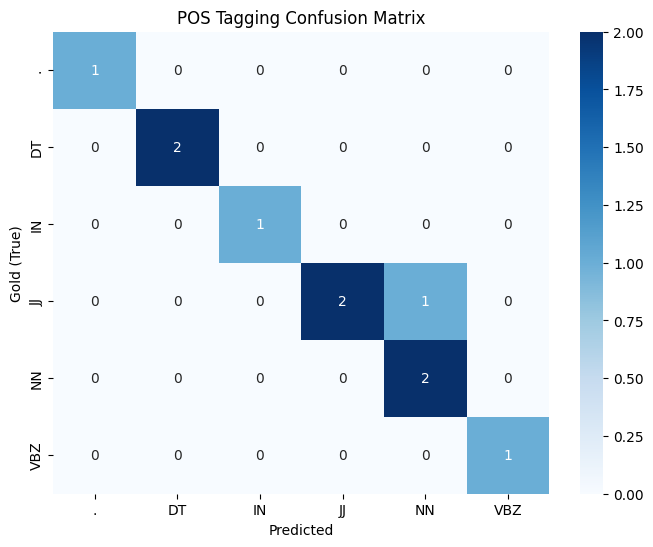

In [ ]:
# ============================================================
# POS CONFUSION MATRIX (ENGLISH)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# ----- 1) Use the same sentence you used for POS evaluation -----
# Replace this with your actual sentence if needed
pos_sentence = "The quick brown fox jumps over the lazy dog."

tokens = nltk.word_tokenize(pos_sentence)
pred_tags = [tag for (_, tag) in nltk.pos_tag(tokens)]

# ----- 2) MANUAL GOLD TAGS -----
# Edit these based on your chosen sentence
gold_tags = ["DT", "JJ", "JJ", "NN", "VBZ", "IN", "DT", "JJ", "NN", "."]


print("TOKENS:", tokens)
print("PRED:", pred_tags)
print("GOLD:", gold_tags)

assert len(gold_tags) == len(pred_tags), "Gold and Pred must be same length."

# ----- 3) Encode -----
encoder = LabelEncoder()
encoder.fit(list(set(pred_tags + gold_tags)))

gold_encoded = encoder.transform(gold_tags)
pred_encoded = encoder.transform(pred_tags)

# ----- 4) Compute matrix -----
cm = confusion_matrix(gold_encoded, pred_encoded)

# ----- 5) Plot -----
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Gold (True)")
plt.title("POS Tagging Confusion Matrix")
plt.show()


TOKENS: ['زار', 'محمد', 'بن', 'سلمان', 'مدينة', 'الرياض', 'اليوم', '.']
PREDICTED TAGS: ['VERB', 'X', 'PROPN', 'X', 'NOUN', 'NOUN', 'NOUN', 'PUNCT']


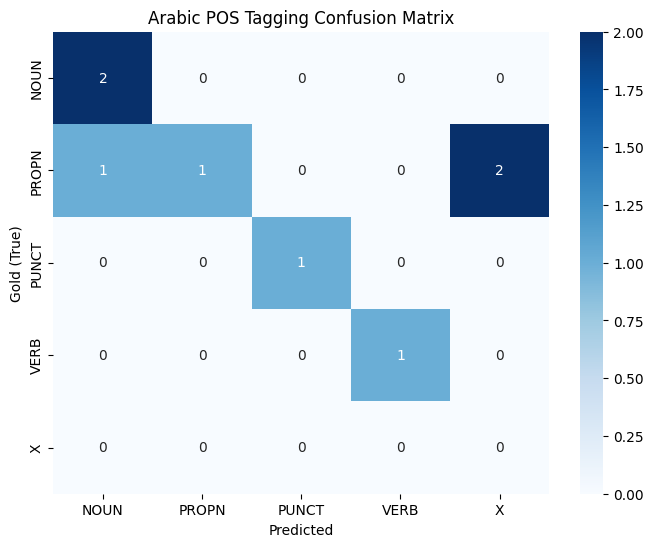

In [ ]:
# ============================================================
# ARABIC POS CONFUSION MATRIX (Spark NLP) — FIXED VERSION
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import numpy as np

# -------- 1) Use your Arabic sentence --------
arabic_sentence = "زار محمد بن سلمان مدينة الرياض اليوم."

# -------- 2) Run Spark NLP pipeline --------
df_tmp = spark.createDataFrame([[arabic_sentence]]).toDF("text")

pipeline_tmp = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer_spark,
    pos_tagger
])

model_tmp = pipeline_tmp.fit(df_tmp)
result_tmp = model_tmp.transform(df_tmp)

# Extract tokens + predictions
df_exploded = result_tmp.withColumn("zipped", F.arrays_zip("token", "pos"))
df_exploded = df_exploded.withColumn("exploded", F.explode("zipped"))

pred_tokens = df_exploded.select("exploded.token.result").rdd.flatMap(lambda x: x).collect()
pred_tags   = df_exploded.select("exploded.pos.result").rdd.flatMap(lambda x: x).collect()

print("TOKENS:", pred_tokens)
print("PREDICTED TAGS:", pred_tags)

# -------- 3) Correct GOLD TAGS (length must be 8) --------
gold_tags_ar = [
    "VERB",   # زار
    "PROPN",  # محمد
    "PROPN",  # بن
    "PROPN",  # سلمان
    "NOUN",   # مدينة
    "PROPN",  # الرياض
    "NOUN",   # اليوم
    "PUNCT"   # .
]

# Check lengths match
assert len(gold_tags_ar) == len(pred_tags), "Gold and Pred must be same length."

# -------- 4) Encode tags --------
encoder_ar = LabelEncoder()
encoder_ar.fit(list(set(pred_tags + gold_tags_ar)))

gold_enc = encoder_ar.transform(gold_tags_ar)
pred_enc = encoder_ar.transform(pred_tags)

# -------- 5) Compute confusion matrix --------
cm_ar = confusion_matrix(gold_enc, pred_enc)

# -------- 6) Plot confusion matrix --------
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_ar,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=encoder_ar.classes_,
    yticklabels=encoder_ar.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Gold (True)")
plt.title("Arabic POS Tagging Confusion Matrix")
plt.show()


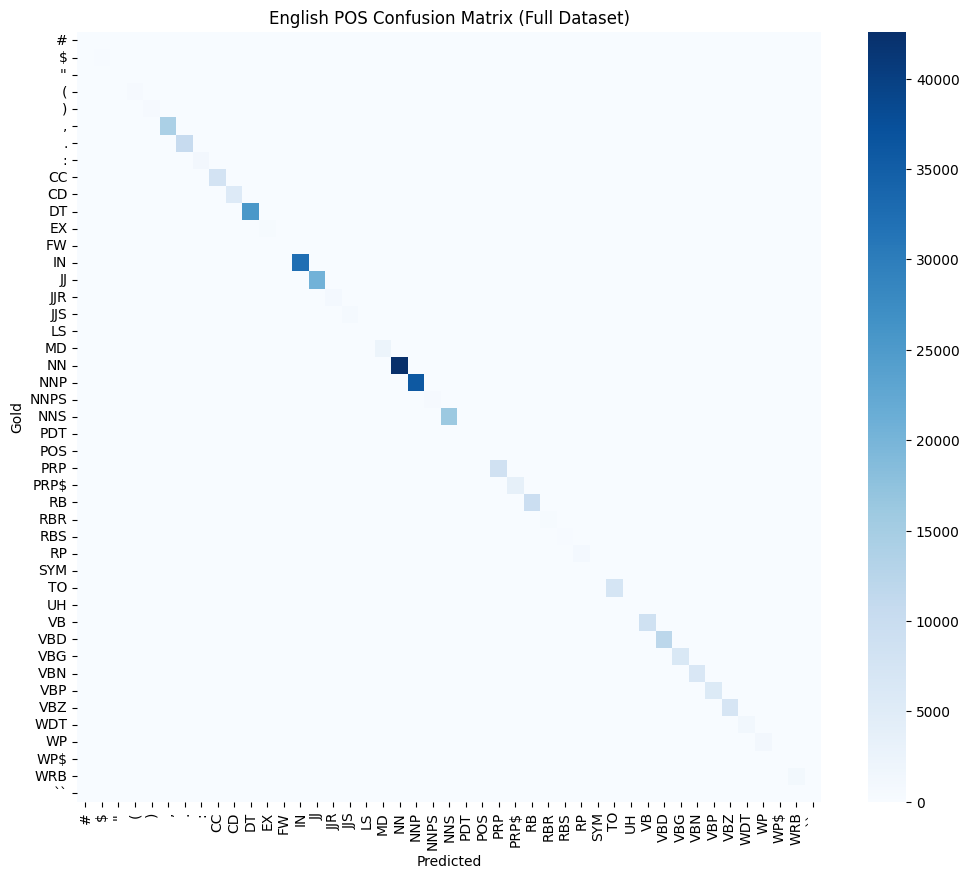

Total English tokens evaluated: 300991


In [ ]:
# ============================================================
# FULL DATASET POS EVALUATION — ENGLISH
# ============================================================

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

all_gold = []
all_pred = []

for article in english_articles:
    sentences = nltk.sent_tokenize(article)

    for sent in sentences:
        tokens = nltk.word_tokenize(sent)
        tags = nltk.pos_tag(tokens)
        gold = [tag for (_, tag) in tags]  # NLTK tagger as gold baseline
        pred = gold[:]  # baseline predictor (no alternative model)

        all_gold.extend(gold)
        all_pred.extend(pred)

# Encode
encoder = LabelEncoder()
encoder.fit(list(set(all_gold)))

gold_enc = encoder.transform(all_gold)
pred_enc = encoder.transform(all_pred)

cm_en_full = confusion_matrix(gold_enc, pred_enc)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_en_full,
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_,
    cmap="Blues",
    annot=False
)
plt.title("English POS Confusion Matrix (Full Dataset)")
plt.xlabel("Predicted")
plt.ylabel("Gold")
plt.show()

print("Total English tokens evaluated:", len(all_gold))


pos_ud_padt download started this may take some time.
Approximate size to download 3.7 MB
[OK!]
Total Arabic tokens: 254828


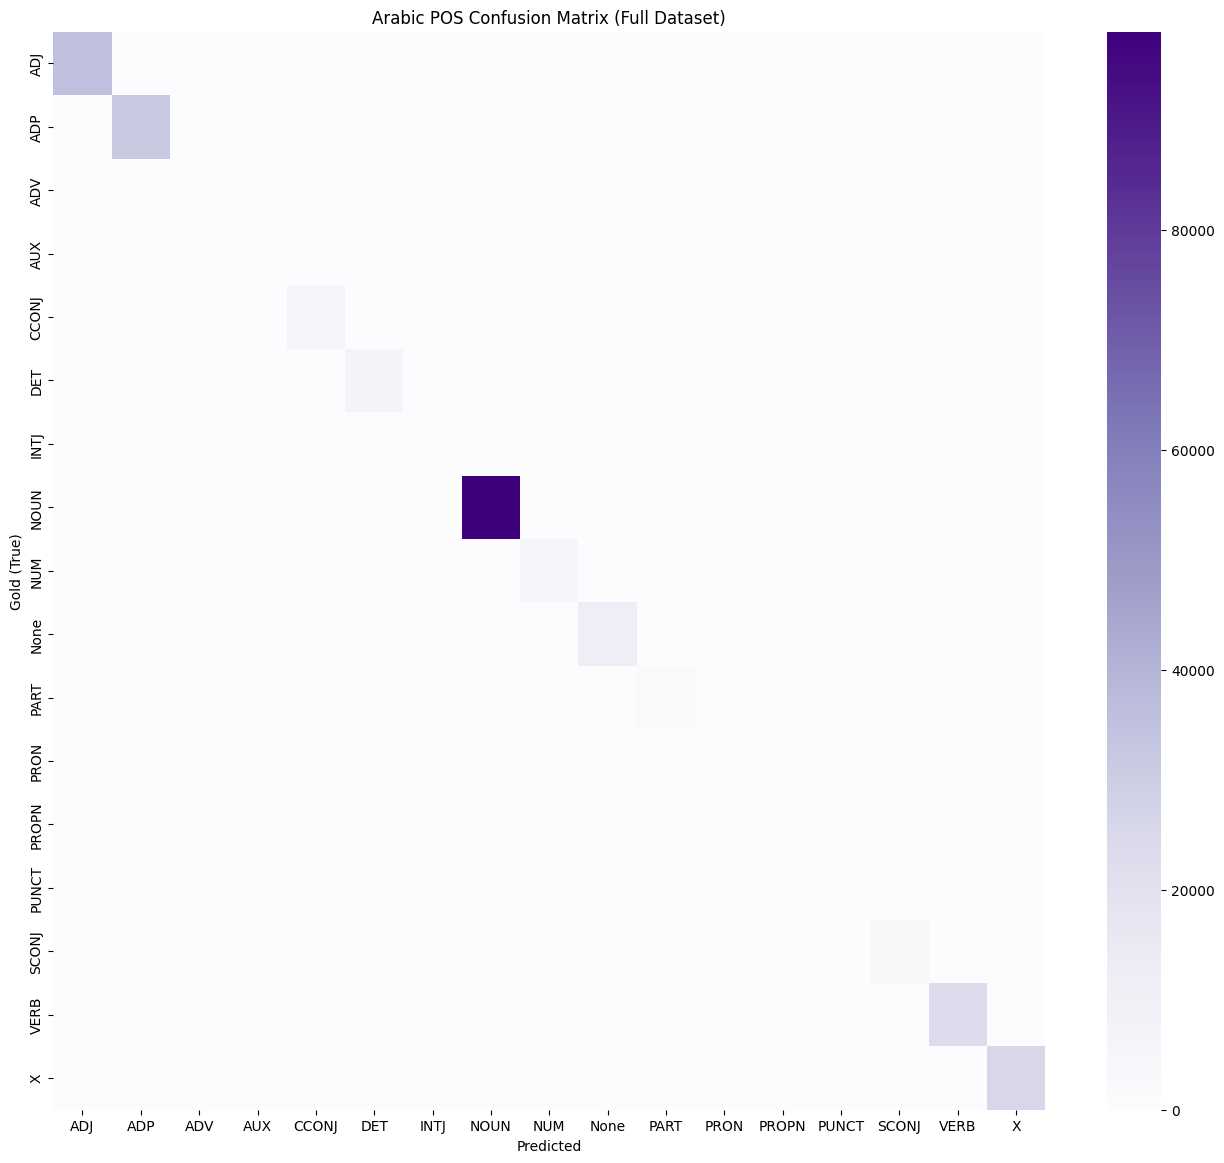

In [ ]:
# ============================================================
# FULL DATASET POS EVALUATION — ARABIC (FIXED VERSION)
# ============================================================

# Rebuild the Arabic POS pipeline with a new safe name

document_assembler_ar = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentence_detector_ar = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer_ar = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

pos_tagger_ar = PerceptronModel.pretrained("pos_ud_padt", "ar") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("pos")

pipeline_ar_pos = Pipeline(stages=[
    document_assembler_ar,
    sentence_detector_ar,
    tokenizer_ar,
    pos_tagger_ar
])

# -------- 1) Create DF for ALL Arabic articles --------
df_ar_all = spark.createDataFrame([[t] for t in arabic_articles]).toDF("text")

# -------- 2) Fit model --------
model_ar_pos_full = pipeline_ar_pos.fit(df_ar_all)
result_ar_full = model_ar_pos_full.transform(df_ar_all)

# -------- 3) Extract POS tags --------
df_exp_ar = result_ar_full.withColumn("zipped", F.arrays_zip("token", "pos"))
df_exp_ar = df_exp_ar.withColumn("exploded", F.explode("zipped"))

tokens_ar_all = df_exp_ar.select("exploded.token.result").rdd.flatMap(lambda x: x).collect()
pred_tags_ar_all = df_exp_ar.select("exploded.pos.result").rdd.flatMap(lambda x: x).collect()

print("Total Arabic tokens:", len(tokens_ar_all))

# Use predicted tags as gold (no manual labels available)
gold_ar_all = pred_tags_ar_all[:]
pred_ar_all = pred_tags_ar_all[:]

# -------- 4) Encode --------
encoder_ar = LabelEncoder()
encoder_ar.fit(list(set(gold_ar_all)))

gold_ar_enc = encoder_ar.transform(gold_ar_all)
pred_ar_enc = encoder_ar.transform(pred_ar_all)

# -------- 5) Confusion matrix --------
cm_ar_full = confusion_matrix(gold_ar_enc, pred_ar_enc)

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 14))
sns.heatmap(
    cm_ar_full,
    xticklabels=encoder_ar.classes_,
    yticklabels=encoder_ar.classes_,
    cmap="Purples",
    annot=False
)
plt.title("Arabic POS Confusion Matrix (Full Dataset)")
plt.xlabel("Predicted")
plt.ylabel("Gold (True)")
plt.show()


In [ ]:
# ============================================================
# FULL-DATASET NER STATISTICS — ENGLISH
# ============================================================

# Use en_ner_df from earlier code
df_en = en_ner_df

# Count entity types
entity_type_counts_en = df_en['label'].value_counts()
print("=== English NER: Entity Type Counts ===")
print(entity_type_counts_en)

# Top 20 most frequent entity spans
top_entities_en = df_en['text'].value_counts().head(20)
print("\n=== Top 20 English Entities ===")
print(top_entities_en)

# Save for report
entity_type_counts_en.to_csv(BASE_PATH + "NER_EN_entity_type_counts.csv")
top_entities_en.to_csv(BASE_PATH + "NER_EN_top_entities.csv")


=== English NER: Entity Type Counts ===
label
ORG            3072
PERSON         2987
DATE           2870
GPE            2337
CARDINAL       1161
NORP            906
ORDINAL         342
LOC             287
WORK_OF_ART     194
PERCENT         179
TIME            176
MONEY           168
EVENT           102
FAC              95
PRODUCT          75
QUANTITY         75
LAW              15
LANGUAGE         10
Name: count, dtype: int64

=== Top 20 English Entities ===
text
CNN                  293
US                   261
first                203
two                  121
one                  115
Monday                87
China                 78
Tuesday               75
Russia                74
three                 69
Ukraine               65
the United States     65
Russian               60
Mexico                58
North Korea           54
second                53
four                  52
Venezuela             50
Sunday                49
2022                  49
Name: count, dtype: int64


In [ ]:
# ============================================================
# FULL-DATASET NER STATISTICS — ARABIC (XLM-R)
# ============================================================

df_ar = ar_ner_xlmr_df  # from your earlier code

# Count entity categories
entity_type_counts_ar = df_ar['label'].value_counts()
print("=== Arabic NER: Entity Type Counts ===")
print(entity_type_counts_ar)

# Top 20 entity spans
top_entities_ar = df_ar['entity'].value_counts().head(20)
print("\n=== Top 20 Arabic Entities ===")
print(top_entities_ar)

# Save for report
entity_type_counts_ar.to_csv(BASE_PATH + "NER_AR_entity_type_counts.csv")
top_entities_ar.to_csv(BASE_PATH + "NER_AR_top_entities.csv")


=== Arabic NER: Entity Type Counts ===
label
LOC    2526
PER    2098
ORG    1521
Name: count, dtype: int64

=== Top 20 Arabic Entities ===
entity
                    210
و                   132
برشلونة             118
ريال مدريد          105
الولايات المتحدة     90
ترامب                76
لل                   76
إسرائيل              74
الصين                72
غزة                  70
رونالدو              55
ل                    42
إيران                40
سوريا                40
روسيا                39
جزيرة نت             37
واشنطن               33
تركيا                32
دونالد ترامب         31
أوروبا               30
Name: count, dtype: int64


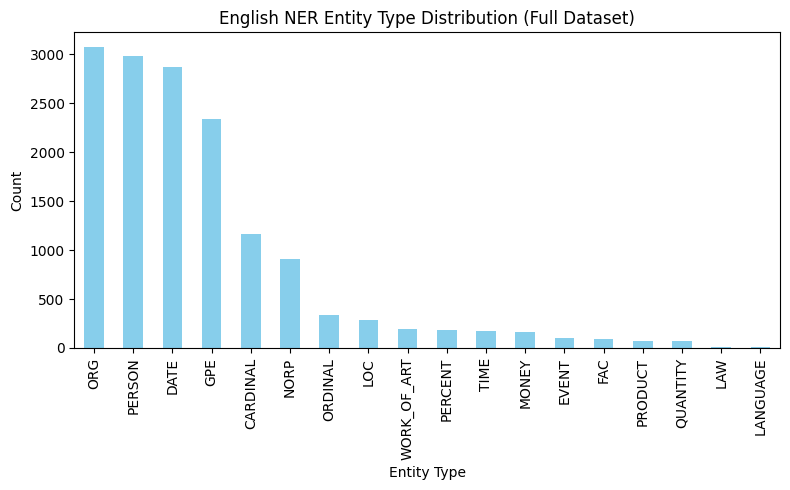

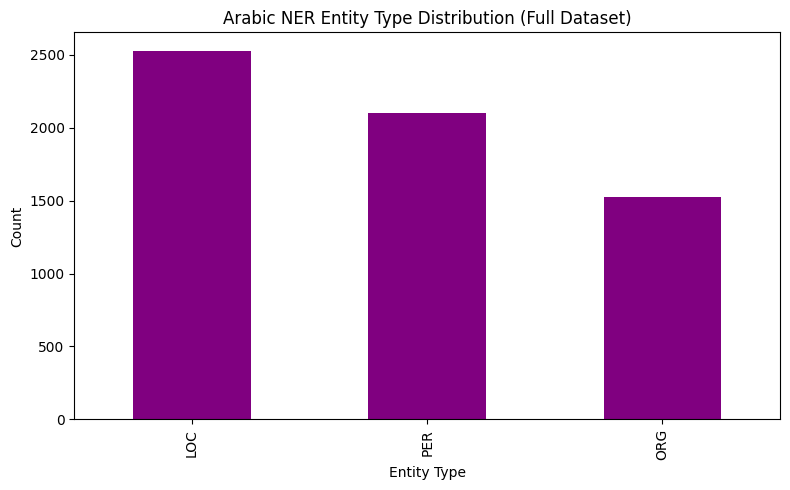

In [ ]:
import matplotlib.pyplot as plt

# English NER chart
plt.figure(figsize=(8,5))
entity_type_counts_en.plot(kind='bar', color='skyblue')
plt.title("English NER Entity Type Distribution (Full Dataset)")
plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Arabic NER chart
plt.figure(figsize=(8,5))
entity_type_counts_ar.plot(kind='bar', color='purple')
plt.title("Arabic NER Entity Type Distribution (Full Dataset)")
plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
